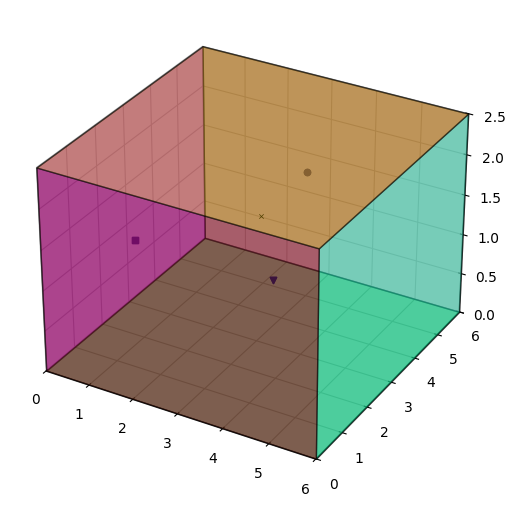

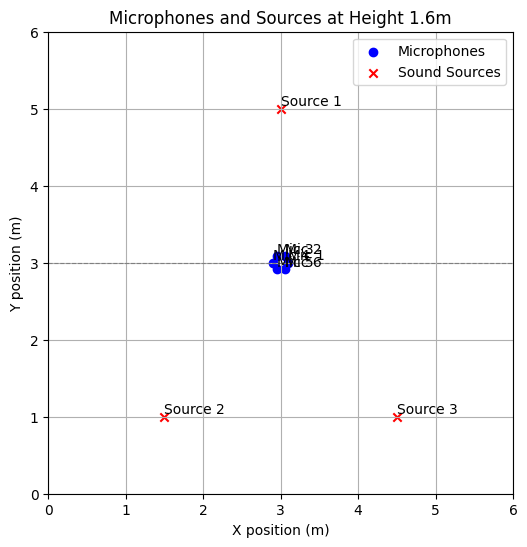

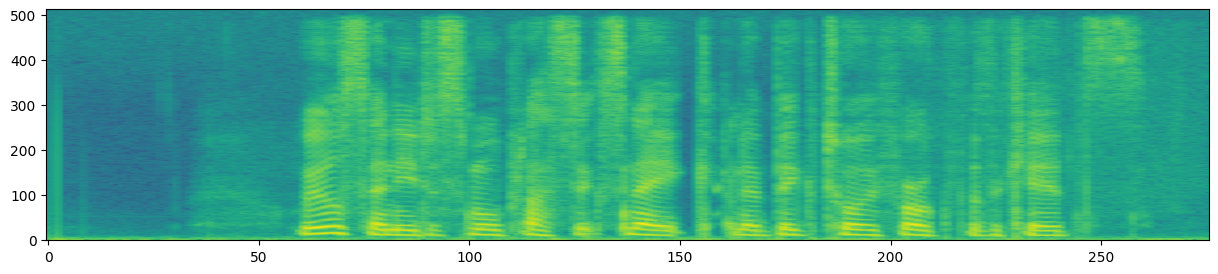

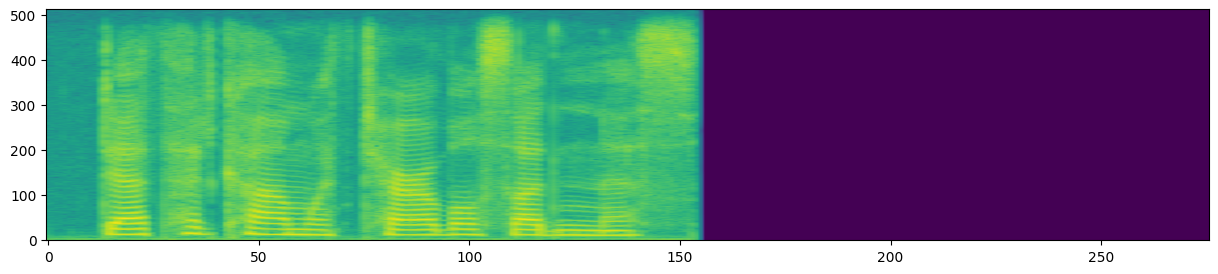

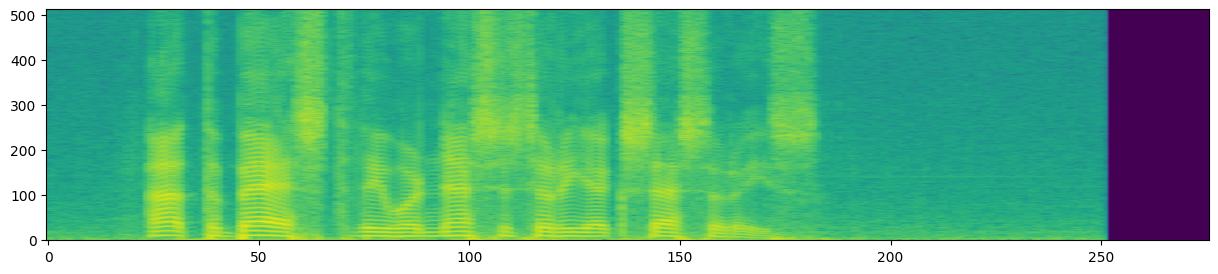

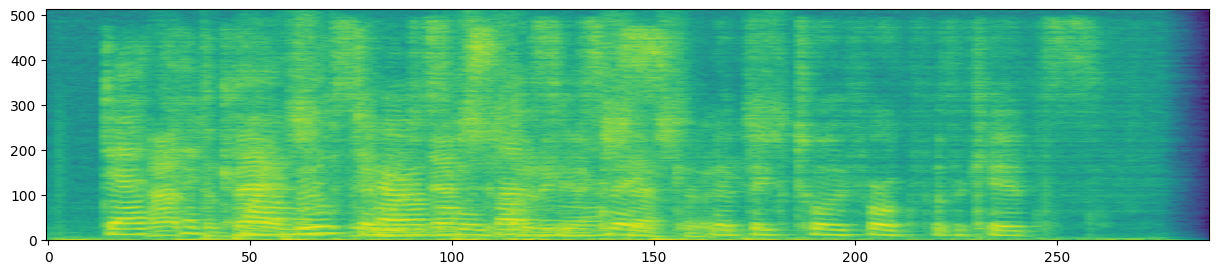

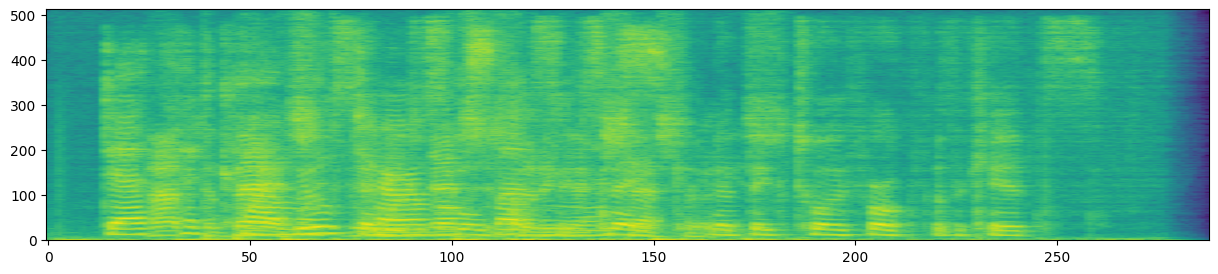

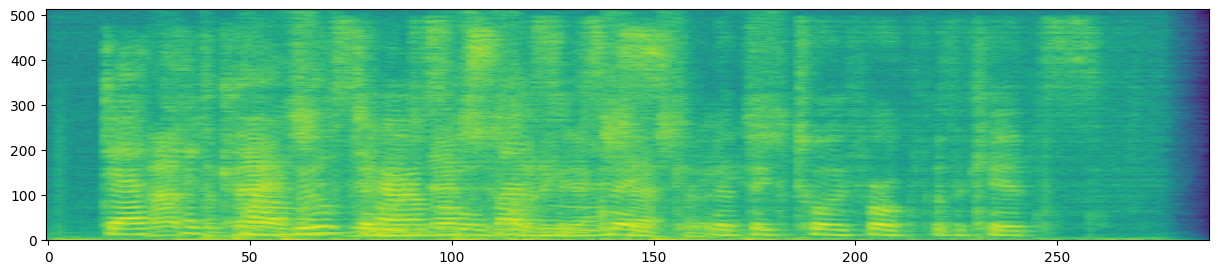

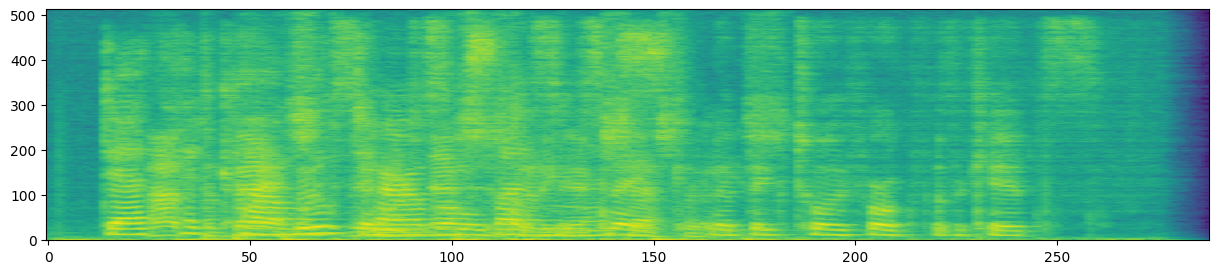

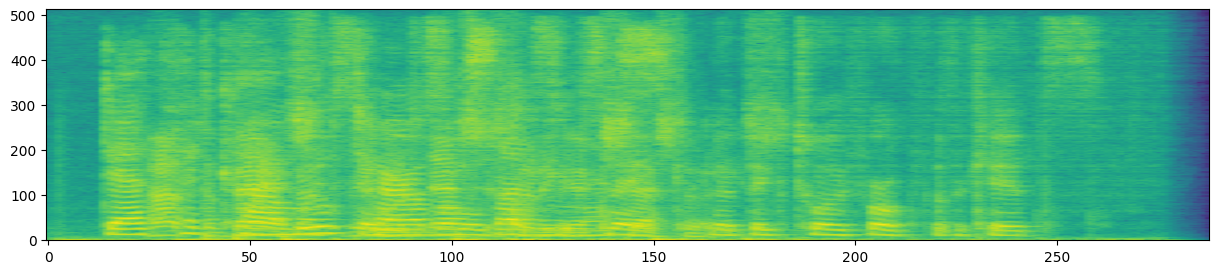

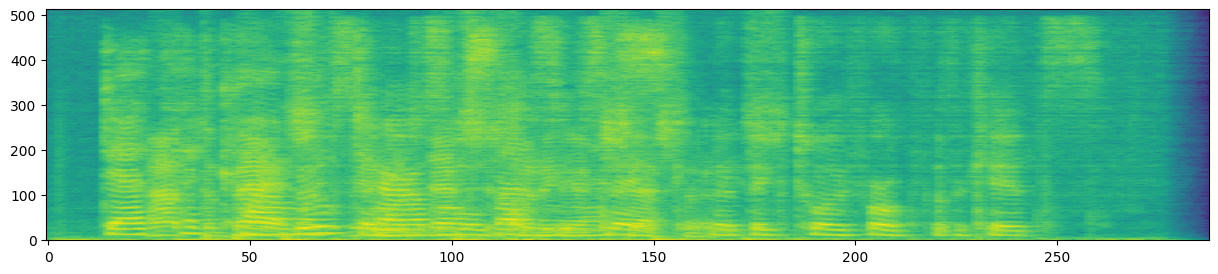

In [3]:
import numpy as np
import soundfile as sf
import librosa
import pickle as pic
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import IPython.display as ipd
import pyroomacoustics as pra
from scipy.io import wavfile

# パラメータ設定
SOUND_SPEED = 340 # 音速
SAMPLING_RATE = 16000 # サンプリング周波数
N_FFT = 1024 # STFTの窓幅
HOP_LENGTH = 256 # STFTのシフト幅
F = int(N_FFT/2 + 1) # 周波数ビン数
MAX_REFRECTION_ORDER = 10 # 反射の最大回数

absorption = 0.6 # 吸音率

# 部屋の設定
room = pra.ShoeBox(
    [6,6,2.5], # Shoebox型で指定(縦*横*高)
    materials = pra.Material(absorption),
    fs = SAMPLING_RATE,
    t0 = 0.0,
    max_order = MAX_REFRECTION_ORDER,
    sigma2_awgn = None,
    sources = None,
    mics = None
)

# マイク設定
center = np.array([3,3,1.6]) #? 部屋の中心を指定. z座標は耳の高さ
M = 6 # マイク数
radius = 0.1

# マイクの配置を自分で指定
angles = np.linspace(0, 2 * np.pi, M, endpoint=False)
mic_locs = np.array([
    [center[0] + radius * np.cos(angle),
     center[1] + radius * np.sin(angle),
     center[2]]
    for angle in angles
]).T
#* room.add_microphoneは(3, M)の形のみ有効. 
#* 転置して(3, M)に

# マイクを配置
for i in range(M):
    room.add_microphone(mic_locs[:, i].reshape(3,1))

#? 複数音源のファイルと配置する位置を指定
# 音源位置
source_locs = np.array([
    [3, 5, center[2]],
    [1.5, 1, center[2]],
    [4.5, 1, center[2]]
])
# 音声ファイル
files = ["data/a01.wav",
         "data/arctic_a0086.wav",
         "data/arctic_b0540.wav"]

# 音源を配置
for position, file in zip(source_locs, files):
    fs, signal = wavfile.read(file)
    room.add_source(position, signal = signal)

# 部屋の形状の可視化
fig, ax = room.plot()
ax.set_ylim([0,6])
ax.set_xlim([0,6])
ax.set_zlim([0,2.5])

# 2D plot
plt.figure(figsize=(6, 6))  # 図のサイズを指定
plt.title("Microphones and Sources at Height 1.6m")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.xlim(0, 6)
plt.ylim(0, 6)

# マイクの位置をプロット
plt.scatter(mic_locs[0], mic_locs[1], label='Microphones', color='blue', marker='o')
# 音源の位置をプロット
plt.scatter(source_locs[:, 0], source_locs[:, 1], label='Sound Sources', color='red', marker='x')
# ラベルの追加
for i, pos in enumerate(source_locs):
    plt.text(pos[0], pos[1], f'Source {i + 1}', fontsize=10, verticalalignment='bottom')
for i, pos in enumerate(mic_locs.T):
    plt.text(pos[0], pos[1], f'Mic {i + 1}', fontsize=10, verticalalignment='bottom')

plt.axhline(y=center[1], color='gray', linestyle='--', linewidth=0.8)  # 中心線を描画
plt.grid()  # グリッドを表示
plt.legend()  # 凡例を表示

plt.show() # マイクおよび音源の高さで切り取った2D平面のプロット

N = len(files) # 音源数

# 生成した音声の可視化・確認
def visualize_spec(Z_FTN):
    for n in range(Z_FTN.shape[2]):
        signal = librosa.core.istft(Z_FTN[:, :, n], hop_length=int((F-1)/2))
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
        plt.imshow(np.log(np.abs(Z_FTN[:, :, n]) +
                          1.0e-8), origin='lower', aspect="auto")
        plt.show()
        ipd.display(ipd.Audio(signal, rate=SAMPLING_RATE))
        # sd.play(signal, samplerate = SAMPLING_RATE)

def visualize_wav(wav_MT):
    M, T = wav_MT.shape

    for m in range(M):
        spec = librosa.core.stft(
            wav_MT[m], n_fft=N_FFT, hop_length=int(N_FFT/4))
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
        plt.imshow(np.log(np.abs(spec) + 1.0e-8),
                   origin='lower', aspect="auto")
        plt.show()
        ipd.display(ipd.Audio(wav_MT[m], rate=SAMPLING_RATE))
        
wav_list = []

for filename in files:
    wav, fs = sf.read(filename)
    wav_list.append(wav)

max_length = max(map(len, wav_list))
wav_NT = np.zeros([N, max_length])  # 長さを揃えた N x Lengthの信号

for n in range(N):
    wav_NT[n, :len(wav_list[n])] = wav_list[n]

visualize_wav(wav_NT)

def convolve_RIR(signal_NT):
    convolved_signals = []
        # 指定した条件での音源からマイクまでの音の伝達をシミュレート
    room.simulate()
    mixture_signal_MT = room.mic_array.signals
    mixture_signal_MT /= np.abs(mixture_signal_MT).max() * 1.2
    
    return mixture_signal_MT

mixture_signal_MT = convolve_RIR(wav_NT)
sf.write("data/mixture_time_domain.wav", mixture_signal_MT.T, 16000)

visualize_wav(mixture_signal_MT)